# Introduccion

Dado un set de datos de accidentes automovilisticos se quieren utilizar tecnicas de Machine Learning para entrenar un modelo y poder predecir o clasificar la severidad de un accidente.


# Tipo de problema

Se desea entrenar el modelo para determinar la severidad de un accidente. La severidad se clasifica entre los valores 1 a 4, siendo 1 el menos severo y 4 el más severo. Dado que debemos clasificar el set de datos con valores discretos lo mas conveniente seria utilizar modelos de clasificacion. 

# Variables y caracteristicas

Interpretar las variables del dataset y como pueden servirnos o no para la estimacion. Por que elegimos las columnas, que nuevas columnas podemos crear a partir de las que tenemos

# Preprocesamiento del set de datos

En este paso se determina el estado del dataset, que datos nos sirven y que se puede mejorar para que el entrenamiento sea satisfactorio.

Ver tp1_dataset_processing.ipynb

In [51]:
#%store -r dataset
import pandas as pd
import numpy as np
dataset = pd.read_feather("dataframe")
print("Datos antes de Particionar")
print(dataset.shape)
dataset = dataset.sample(None, 0.2);
print("Datos despues de particionar")
print(dataset.shape)
dataset.info()

Datos antes de Particionar
(933236, 176)
Datos despues de particionar
(186647, 176)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 186647 entries, 223852 to 151921
Columns: 176 entries, index to Sunrise_Sunset_Night
dtypes: bool(13), float64(9), int32(2), int64(2), timedelta64[ns](1), uint8(149)
memory usage: 48.8 MB


In [52]:
#Convierto el tiempo a horas para que quede mas comodo
dataset["Time_Elapsed"] = dataset["Time_Elapsed"].astype(np.timedelta64) / np.timedelta64(1, 'h')

# Modelos de prediccion a aplicar

Aca entraria una breve explicacion de que modelos vamos a usar y el por que

* Formalizar tecnica de seleccion de datos
* Evaluar modelos usados segun resultado obtenido
* Comentar ventajas y desventajas de los modelos elegidos

In [53]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics

import time

In [54]:
X = dataset #Features a entrenar
y = dataset.pop("Severity") #Datos de target

#Funcion auxiliar para escalar y dividir los datos
def scale_data(X,y):
    #Separamos el dataset en partes de entrenamiento y de testeo
    X_train, X_test, Y_train, Y_test = train_test_split(X,y)

    scaler = MinMaxScaler()
    #Entrenamos el scaler con los datos del set de entrenamiento
    scaler.fit(X_train)

    #Aplicamos la transformacion a ambos sets de entrenamiento y de testeo
    norm_x_train = scaler.transform(X_train)
    norm_x_test = scaler.transform(X_test)
    
    return norm_x_train, norm_x_test, Y_train, Y_test



Para escalar los datos usamos MinMaxScaler, entrenado con la particion de entrenamiento. Esto es porque en la vida real la particion de test no la conocemos hasta tratar de predecir con un modelo ya entrenado. Por eso hacemos fit sobre X_train y transform en ambos X_train y X_test, logrando simular la realidad.

# Modelo 1: SGD (Stochastic Gradient Descent) Classifier - Aplicando SGD a SVM

SGD enfoque simple y muy eficiente para adaptarse a modelos lineales. Es particularmente útil cuando el número de muestras es muy grande. Admite diferentes funciones de pérdida y penalizaciones por clasificación.

In [47]:
#Escalamos los datos
print("Scaling Starting...")
start_time = time.time()
norm_x_train, norm_x_test, y_train, y_test = scale_data(X,y)
end_time = time.time()
print(f"Scaling done. Durarion: {round(end_time-start_time,2)}")

i_range = [20, 40, 60, 80, 120, 600, 1200]
sgd_train_score = []
sgd_test_score = []
for i in i_range:
    print("Sgd training starting...")
    start_time = time.time()
    est = SGDClassifier(alpha=1e-5, average = i)
    est.fit(norm_x_train, y_train)
    end_time = time.time()
    print(f"fit done with average {i}. Duration: {round(end_time-start_time,2)}")
    #y_pred = est.predict(norm_x_test)
    #scores[i] = metrics.accuracy_score(y_test, y_pred)
    #list_scores.append(metrics.accuracy_score(y_test, y_pred))
    score_train = est.score(norm_x_train, y_train)
    score_test = est.score(norm_x_test, y_test)
    print("Train Score: {0}".format(score_train))
    print("Test Score: {0}".format(score_test))
    sgd_train_score.append(score_train)
    sgd_test_score.append(score_test)



Scaling Starting...
Scaling done. Durarion: 1.43
Sgd training starting...
fit done with average 20. Duration: 5.35
Train Score: 0.70068
Test Score: 0.69672
Sgd training starting...
fit done with average 40. Duration: 5.87
Train Score: 0.7005066666666667
Test Score: 0.69684
Sgd training starting...
fit done with average 60. Duration: 5.89
Train Score: 0.7001333333333334
Test Score: 0.69664
Sgd training starting...
fit done with average 80. Duration: 7.01
Train Score: 0.7003733333333333
Test Score: 0.69672
Sgd training starting...
fit done with average 120. Duration: 5.79
Train Score: 0.70052
Test Score: 0.6966
Sgd training starting...
fit done with average 600. Duration: 5.97
Train Score: 0.7002666666666667
Test Score: 0.69656
Sgd training starting...
fit done with average 1200. Duration: 6.7
Train Score: 0.7004666666666667
Test Score: 0.6968


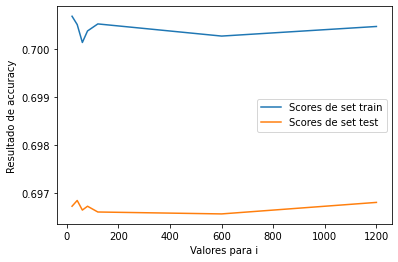

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(i_range, sgd_train_score, label="Scores de set train")
plt.plot(i_range, sgd_test_score, label="Scores de set test")
plt.xlabel("Valores para i")
plt.ylabel("Resultado de accuracy")
plt.legend()

Si elegimos el el valor promedio a partir de 22 y 35 obtenemos la mejor relacion entre overfitting y underfitting


# Modelo 2: Clasificador KNN

La clasificación basada en vecinos es un tipo de aprendizaje perezoso, ya que no intenta construir un modelo interno general, sino que simplemente almacena instancias de los datos de entrenamiento. La clasificación se calcula a partir de un voto de mayoría simple de los k vecinos más cercanos de cada punto.

In [11]:
#Scaling the data
print("Scaling Starting...")
start_time = time.time()
norm_x_train, norm_x_test, y_train, y_test = scale_data(X,y)
end_time = time.time()
print(f"Scaling done. Durarion: {round(end_time-start_time,2)}")

#Definimos un rango de Ks para probar
k_range = [5, 15, 25, 35, 45]
#Nos guardamos los scores de entrenamiento para graficar luego.
knn_train_score = []
knn_test_score = []

for k in k_range: #Automaticamente testeamos el modelo para k entre 1 y k_range, y nos guardamos el accuracy de cada uno
    print("Knn Starting...",k)
    start_time = time.time()
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(norm_x_train,y_train)
    end_time = time.time()
    print(f"Knn with k = {k} done. Duration: {round(end_time-start_time,2)}")
    #y_pred = knn.predict(norm_x_test)
    #print("Pred done")
    knn_train_score.append(knn.score(norm_x_train, y_train))
    knn_test_score.append(knn.score(norm_x_test, y_test))
    print(f"Done with {k}")

Scaling Starting...
Scaling done. Durarion: 1.66
Knn Starting... 5
Knn with k = 5 done. Duration: 0.03
Done with 5
Knn Starting... 15
Knn with k = 15 done. Duration: 0.02
Done with 15
Knn Starting... 25
Knn with k = 25 done. Duration: 0.02
Done with 25
Knn Starting... 35
Knn with k = 35 done. Duration: 0.02
Done with 35
Knn Starting... 45
Knn with k = 45 done. Duration: 0.02
Done with 45


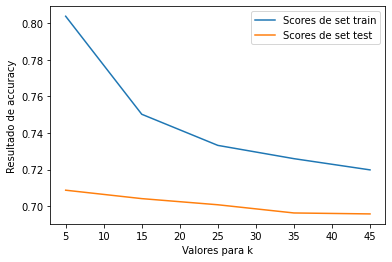

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(k_range, knn_train_score, label="Scores de set train")
plt.plot(k_range, knn_test_score, label="Scores de set test")
plt.xlabel("Valores para k")
plt.ylabel("Resultado de accuracy")
plt.legend()

# Modelo 3: Clasificador MLP (Multi-layered Perceptron)

Una red neuronal es un conjunto de neuronas (funciones de activación) en capas que se procesan secuencialmente para relacionar una entrada con una salida. Este ejemplo implementa un algoritmo de perceptrón multicapa (MLP) donde probamos los distintos algoritmos de resolucion.

In [17]:
#Scaling the data
print("Scaling Starting...")
start_time = time.time()
norm_x_train, norm_x_test, y_train, y_test = scale_data(X,y)
end_time = time.time()
print(f"Scaling done. Durarion: {round(end_time-start_time,2)}")

mlp_train_score = []
mlp_test_score = []

solvers = ["lbfgs","sgd", "adam"]
for itr in solvers:
    print(f"Starting training with {itr}")
    start_time = time.time()
    clf = MLPClassifier(solver="itr",alpha=1e-5,max_iter=1000,activation='relu',hidden_layer_sizes=[10, 50, 50], random_state=1, shuffle=True)
    clf.fit(norm_x_train,y_train)
    end_time = time.time()
    print(f"Finished training with {itr}. Duration: {round(end_time-start_time,2)}")
    #y_pred = clf.predict(norm_x_test)
    mlp_train_score.append(clf.score(norm_x_train,y_train))
    mlp_test_score.append(clf.score(norm_x_test,y_test))
    print(f"Done with {itr}")



Scaling Starting...
Scaling done. Durarion: 1.4
Starting training with lbfgs


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Finished training with lbfgs. Duration: 255.92
Done with lbfgs
Starting training with sgd
Finished training with sgd. Duration: 462.11
Done with sgd
Starting training with adam
Finished training with adam. Duration: 217.0
Done with adam


Train Score: [0.7924933333333334, 0.78656, 0.8060533333333333]


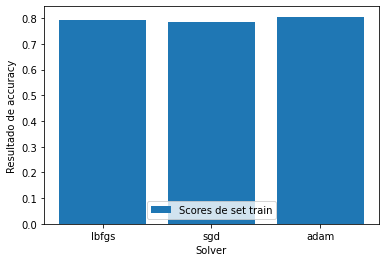

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(solvers, mlp_train_score, label="Scores de set train")
plt.xlabel("Solver")
plt.ylabel("Resultado de accuracy")
plt.legend()

print("Train Score: {0}".format(mlp_train_score))

Test Score: [0.7902, 0.78656, 0.79128]


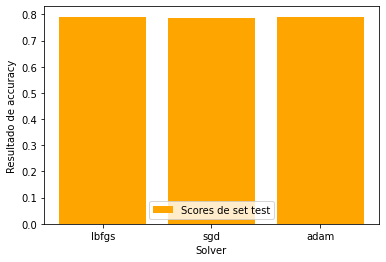

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.bar(solvers, mlp_test_score, label="Scores de set test", color = 'orange')
plt.xlabel("Solver")
plt.ylabel("Resultado de accuracy")
plt.legend()
print("Test Score: {0}".format(mlp_test_score))

In [55]:
#Scaling the data
print("Scaling Starting...")
start_time = time.time()
norm_x_train, norm_x_test, y_train, y_test = scale_data(X,y)
end_time = time.time()
print(f"Scaling done. Durarion: {round(end_time-start_time,2)}")

mlp_train_score = []
mlp_test_score = []
epoch_score = []

epochs = [25, 50, 75, 100, 150, 200, 250, 500, 750]
for itr in epochs:
    print(f"Starting training with {itr}")
    start_time = time.time()
    clf = MLPClassifier(solver="adam",alpha=1e-5,max_iter=itr,activation='relu',hidden_layer_sizes=[10, 10, 10], random_state=1, shuffle=True)
    clf.fit(norm_x_train,y_train)
    end_time = time.time()
    print(f"Finished training with {itr}. Duration: {round(end_time-start_time,2)}")
    #y_pred = clf.predict(norm_x_test)
    mlp_train_score.append(clf.score(norm_x_train,y_train))
    mlp_test_score.append(clf.score(norm_x_test,y_test))
    epoch_score.append(itr)
    print(f"Done with {itr}")

Scaling Starting...
Scaling done. Durarion: 2.45
Starting training with 25


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training with 25. Duration: 33.03
Done with 25
Starting training with 50


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training with 50. Duration: 65.7
Done with 50
Starting training with 75


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training with 75. Duration: 95.97
Done with 75
Starting training with 100


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training with 100. Duration: 128.82
Done with 100
Starting training with 150


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training with 150. Duration: 193.48
Done with 150
Starting training with 200


c:\users\tplaz\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Finished training with 200. Duration: 254.95
Done with 200
Starting training with 250
Finished training with 250. Duration: 326.5
Done with 250
Starting training with 500
Finished training with 500. Duration: 328.97
Done with 500
Starting training with 750
Finished training with 750. Duration: 329.18
Done with 750


Train Score: [0.7863913990784727, 0.7899417794763725, 0.7943065328428046, 0.7954709433153552, 0.7961138693431439, 0.79557809765332, 0.7972854234382255, 0.7972854234382255, 0.7972854234382255]
Test Score: [0.7821567871072822, 0.7867858214392868, 0.7907076421927907, 0.7906219193347906, 0.7912862714842913, 0.7912862714842913, 0.7927221293557927, 0.7927221293557927, 0.7927221293557927]


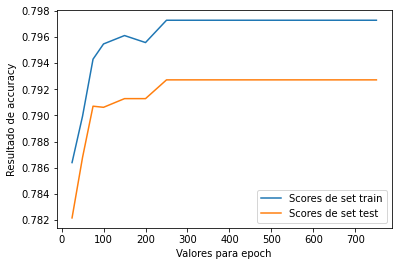

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(epoch_score, mlp_train_score, label="Scores de set train")
plt.plot(epoch_score, mlp_test_score, label="Scores de set test")
plt.xlabel("Valores para epoch")
plt.ylabel("Resultado de accuracy")
plt.legend()

print("Train Score: {0}".format(mlp_train_score))
print("Test Score: {0}".format(mlp_test_score))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(epoch_score, mlp_train_score, label="Scores de set train")
plt.plot(epoch_score, mlp_test_score, label="Scores de set test")
plt.xlabel("Valores para epoch")
plt.ylabel("Resultado de accuracy")
plt.legend()

print("Train Score: {0}".format(mlp_train_score))
print("Test Score: {0}".format(mlp_test_score))

# Modelo 3 LinearSVC
Este fue un intento con LinearSVC para ver que diferencia presenta en el rendimiento con el SGDLinearRegression. Pero realizando las pruebas vimos
que experimentaba mucho overfitting. Lo que lleva a la conclusion de que nuestro modelo es muy complejo. 

# Posibles sugerencias para evitar el overfitting.

- Eliminar algunas caracteristicas de los datos
- Aplicar regularizacion a los modelos lineales.

In [42]:
#Escalamos los datos
print("Iniciamos Escalado de Datos...")
start_time = time.time()
scaled_X_train, scaled_X_test, y_train, y_test = scale_data(X,y)
end_time = time.time()
print(f"Escalado Terminado con Duracion: {round(end_time-start_time,2)}")

print("Modelo Lineal SVC iniciando entrenamiento")
start_time = time.time();
modelo = LinearSVC(dual=False, C=0.25);
modelo.fit(scaled_X_train, y_train)
end_time = time.time()

print(f"Tiempo de Entrenamiento del Modelo: {round(end_time-start_time,2)}")
score_train = modelo.score(scaled_X_train, y_train)
score_test = modelo.score(scaled_X_test, y_test)

print("Train Score: {0}".format(score_train))
print("Test Score: {0}".format(score_test))

Iniciamos Escalado de Datos...
Escalado Terminado con Duracion: 1.42
Modelo Lineal SVC iniciando entrenamiento
Tiempo de Entrenamiento del Modelo: 4.39
Train Score: 0.6967066666666667
Test Score: 0.69608


# Presentacion de los resultados obtenidos

Aca mostrar resultados de las predicciones, graficos o lo que sea